In [1]:
%load_ext autoreload
import os,sys
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import progressbar
import random
from datetime import datetime
sys.path.append("../")

print(sys.path)
import hdbscan, umap
%autoreload 2

from src.pySRM.pysrm.regions import SpectraRegion, ProteinWeights
from src.pySRM.pysrm.imzml import IMZMLExtract
from src.pySRM.pysrm.comparative import CombinedSpectra


from collections import Counter, defaultdict

import imageio
from sklearn import tree
from skimage.color import rgb2gray,rgba2rgb

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display# load dataset


['/mnt/f/dev/git/pyIMS/examples', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/local/lib/python3.8/dist-packages/mpld3-0.3.1.dev1-py3.8.egg', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/home/mjoppich/.ipython', '../']


In [2]:
! ls /mnt/f/dev/data/msi/AL1_1

200213_AL1_1.ibd    200213_AL1_1.imzML.regions	200213_AL1_1_spotlist.txt
200213_AL1_1.imzML  200213_AL1_1_Plot.jpg


In [3]:
imze = IMZMLExtract("/mnt/f/dev/data/msi/AL1_1/200213_AL1_1.imzML")

Opening regions file for /mnt/f/dev/data/msi/AL1_1/200213_AL1_1.imzML


0 ((4449, 4505, 938, 1002), 3705)
1 ((4490, 4532, 1365, 1415), 2180)
2 ((3542, 3644, 1195, 1262), 7004)
3 ((2409, 2502, 1572, 1633), 5828)
4 ((4559, 4646, 1158, 1250), 8158)
5 ((2317, 2372, 1400, 1490), 5096)
6 ((2317, 2387, 1648, 1702), 3905)


<Figure size 1440x864 with 0 Axes>

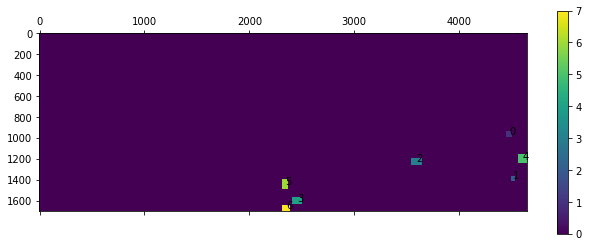

{0: ((4449, 4505, 938, 1002), 3705),
 1: ((4490, 4532, 1365, 1415), 2180),
 2: ((3542, 3644, 1195, 1262), 7004),
 3: ((2409, 2502, 1572, 1633), 5828),
 4: ((4559, 4646, 1158, 1250), 8158),
 5: ((2317, 2372, 1400, 1490), 5096),
 6: ((2317, 2387, 1648, 1702), 3905)}

In [4]:
plt.figure(figsize=(20, 12))
imze.list_regions()

In [29]:
spectra_orig2 = imze.get_region_array(2, makeNullLine=True)


Found region 2 with shape (103, 68, 38800)


In [5]:
avg_region_spectrum = imze.get_avg_region_spectrum(2)

Found region 2 with shape (103, 68, 38800)


In [6]:
sp2_called, sp2_called_masses = imze.to_called_peaks(np.array([[avg_region_spectrum]]), imze.mzValues, resolution=4)

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


459.90595210980695 2000.2994838848333
460.0 2000.25
(1, 1, 6162)
(6162,)


In [7]:
spectra_orig4 = imze.get_region_array(4, makeNullLine=True)
sh_sporig_bg4, sh_masses_sporig_bg4 = imze.shift_region_array(spectra_orig4, imze.mzValues, maxshift=20)
sp4_called, sp4_called_masses = imze.to_called_peaks(sh_sporig_bg4, sh_masses_sporig_bg4, resolution=4)
sp4_called_nobg, sp4_called_nobg_masses = imze.remove_background_spec_aligned(sp4_called, sp2_called[0,0,2:-4], sp4_called_masses, 5)

Found region 4 with shape (88, 93, 38800)
100% (8184 of 8184) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


Shifts: mean: 11.789589442815249, median: 13.0


N/A% (0 of 88) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

460.6999898591175 1999.5054461355228
460.75 1999.5
(88, 93, 6156)
(6156,)


100% (88 of 88) |########################| Elapsed Time: 0:03:51 Time:  0:03:51
|###########                                              |  20% ETA:   0:00:00

(6156,)
(88, 93, 6156)


|#########################################################| 100% Time:  0:00:00


avg shift 0.009408602150537635


In [8]:
spectra_orig3 = imze.get_region_array(3, makeNullLine=True)
sh_sporig_bg3, sh_masses_sporig_bg3 = imze.shift_region_array(spectra_orig3, imze.mzValues, maxshift=20)
sp3_called, sp3_called_masses = imze.to_called_peaks(sh_sporig_bg3, sh_masses_sporig_bg3, resolution=4)
sp3_called_nobg, sp3_called_nobg_masses = imze.remove_background_spec_aligned(sp3_called, sp2_called[0,0,3:-3], sp3_called_masses, 5)

Found region 3 with shape (94, 62, 38800)
100% (5828 of 5828) |####################| Elapsed Time: 0:00:03 Time:  0:00:03


Shifts: mean: -1.4826698695950584, median: -1.0


N/A% (0 of 94) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

460.6999898591175 1999.5054461355228
460.75 1999.5
(94, 62, 6156)
(6156,)


100% (94 of 94) |########################| Elapsed Time: 0:00:30 Time:  0:00:30
|##############                                           |  25% ETA:   0:00:00

(6156,)
(94, 62, 6156)


|#########################################################| 100% Time:  0:00:00


avg shift 0.004804392587508579


In [9]:
sp3_called_nobg_norm = imze.normalize_region_array(sp3_called_nobg, normalize="vector")

In [10]:
np.array([1,1,1,1]) / np.array([2,2,2,2])

array([0.5, 0.5, 0.5, 0.5])

In [11]:
sp3_called_nobg_norm_intra = imze.normalize_region_array(sp3_called_nobg, normalize="intra_median")

Got 0 median-enabled pixels


In [13]:
sp3_called_nobg_norm_inter = imze.normalize_region_array(sp3_called_nobg_norm_intra, normalize="inter_median")

Got a total of 35818888 fold changes
Median elements [17909444]
Median elements
Global Median 0.0


intra/inter normalization does not have any effect, because median == 0!

459.90595210980695 154
476.6601486202598 4
483.64768081419277 31
490.63521300812573 3014
497.6227452020587 2594
504.5705755085261 8
506.9526887564578 1
507.03209253138886 1
511.55810770245904 3
512.987375651218 1
513.0270775386836 13
513.3049907509424 1
518.545639896392 3


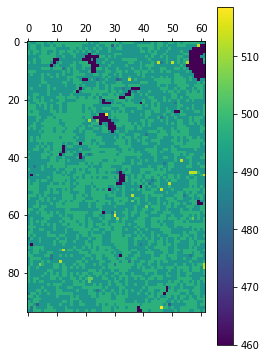

5828 0.0 1.0 0.47724874037229476


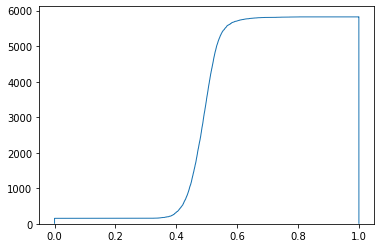

In [14]:
imze.list_highest_peaks(sp3_called_nobg_norm, counter=True)

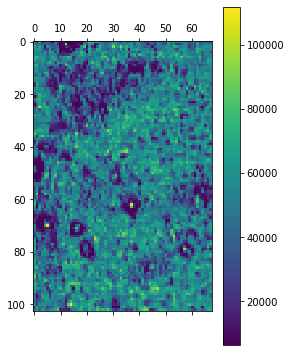

In [30]:
imze.plot_toc(spectra_orig2)

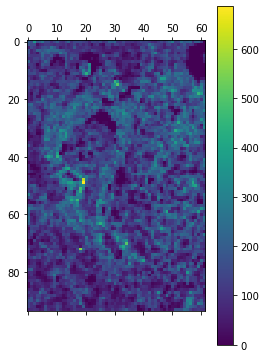

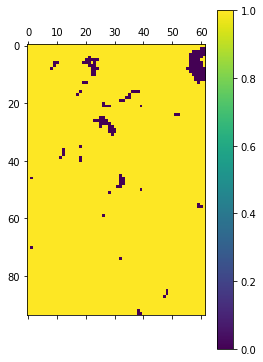

In [48]:
imze.plot_tnc(sp3_called_nobg)
imze.plot_tnc(sp3_called_nobg_norm)

In [46]:
sp3_called_nobg_norm = imze.normalize_region_array(sp3_called_nobg, normalize="vector")

print(np.linalg.norm(sp3_called_nobg[0,0,:]))
print(np.linalg.norm(sp3_called_nobg_norm[0,0,:]))


201.59079901696495
1.0


In [15]:
def plot_coords(arr, coords, valRange, xvals):
    for x in coords:
        plt.plot(xvals, arr[x], label=str(x))
        
    plt.xlim(valRange)
    plt.legend()
    
def plot_coords_vec(arr, valRange, xvals):       
    plt.plot(xvals[valRange], arr[valRange], label="(00, 00)")
    plt.legend()

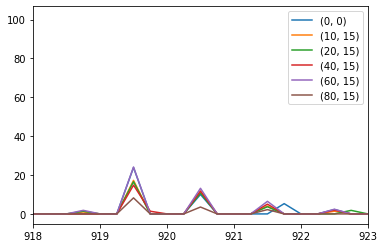

In [16]:
plot_coords(sp3_called, [(0,0),(10,15), (20,15), (40,15), (60,15), (80,15)], (918,923), sp3_called_masses)

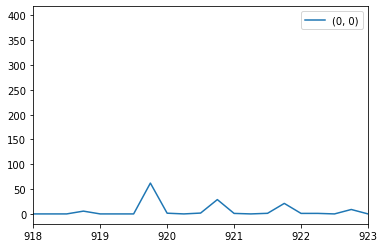

In [17]:
plot_coords(sp2_called[:,:,3:-3], [(0,0)], (918,923), sp2_called_masses[4:-2])

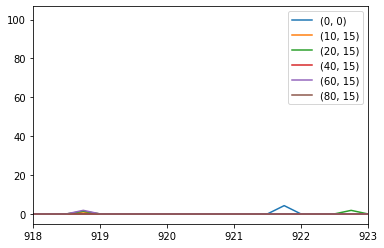

In [18]:
plot_coords(sp3_called_nobg, [(0,0),(10,15), (20,15), (40,15), (60,15), (80,15)], (918,923), sp3_called_nobg_masses)

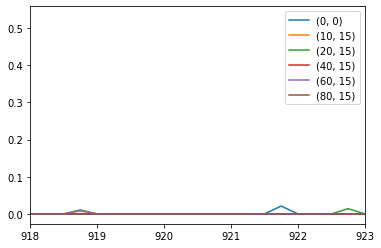

In [19]:
plot_coords(sp3_called_nobg_norm, [(0,0),(10,15), (20,15), (40,15), (60,15), (80,15)], (918,923), sp3_called_nobg_masses)

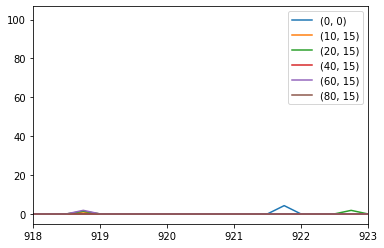

In [20]:
plot_coords(sp3_called_nobg_norm_intra, [(0,0),(10,15), (20,15), (40,15), (60,15), (80,15)], (918,923), sp3_called_nobg_masses)

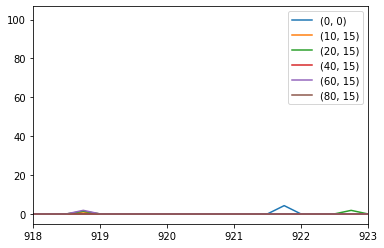

In [21]:
plot_coords(sp3_called_nobg_norm_inter, [(0,0),(10,15), (20,15), (40,15), (60,15), (80,15)], (918,923), sp3_called_nobg_masses)

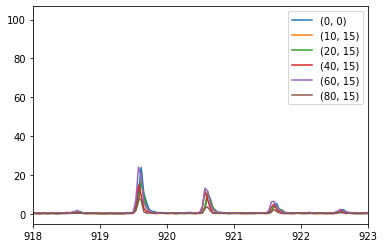

In [22]:
plot_coords(sh_sporig_bg3, [(0,0),(10,15), (20,15), (40,15), (60,15), (80,15)], (918,923), sh_masses_sporig_bg3)

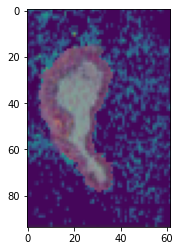

In [23]:
aorta_mask_blended = np.round(imageio.imread("aorta_mask_blended.png"))
plt.imshow(aorta_mask_blended)

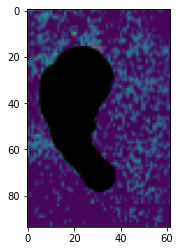

In [24]:
aorta_mask_blended = np.round(imageio.imread("aorta_mask_blended_mask.png"))
plt.imshow(aorta_mask_blended)

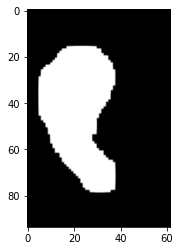

In [25]:
manual_mask = ~np.round(imageio.imread("aorta_test_lipids_2.png"))
plt.imshow(manual_mask)

In [49]:
spec_4= SpectraRegion(sp4_called_nobg, sp4_called_nobg_masses)
spec_4.calculate_similarity(mode="spectra_log")

2020-09-26 00:35:39,391  SpectraRegion  INFO: Creating C++ obj
2020-09-26 00:35:39,392  SpectraRegion  INFO: 6146 (88, 93, 6146)
2020-09-26 00:35:39,392  SpectraRegion  INFO: dimensions 6146
2020-09-26 00:35:39,393  SpectraRegion  INFO: input dimensions (88, 93, 6146)
2020-09-26 00:35:39,393  SpectraRegion  INFO: Switching to dot mode
2020-09-26 00:35:39,470  SpectraRegion  INFO: Starting calc similarity c++


6146


2020-09-26 00:38:23,377  SpectraRegion  INFO: outclust dimensions (8184, 8184)
2020-09-26 00:38:23,388  SpectraRegion  INFO: Calculating spectra similarity
2020-09-26 00:38:23,665  SpectraRegion  INFO: Calculating spectra similarity done


array([[1.       , 0.985136 , 0.982002 , ..., 0.       , 0.       ,
        0.       ],
       [0.985136 , 1.       , 0.9842724, ..., 0.       , 0.       ,
        0.       ],
       [0.982002 , 0.9842724, 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 1.       ,
        1.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 1.       ,
        1.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 1.       ,
        1.       ]], dtype=float32)

In [50]:
spec_4.segment(method="WARD", number_of_regions=10)

2020-09-26 00:38:23,688  SpectraRegion  INFO: Calculating clusters
2020-09-26 00:38:25,768  SpectraRegion  INFO: Calculating clusters done
2020-09-26 00:38:25,792  SpectraRegion  INFO: Calculating clusters saved


array([[ 4,  4,  4, ...,  4, 10,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  8,  8,  8],
       [ 2,  3,  4, ...,  8,  8,  6],
       [ 3,  3,  4, ...,  9,  9,  9]], dtype=int16)

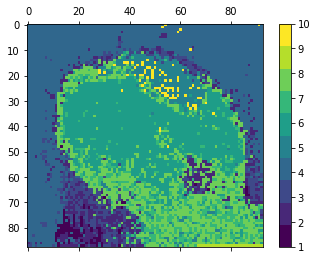

In [51]:
spec_4.plot_segments()

In [52]:
spec_percentile=None

Let's see whether the unsupervised approach works better now?

In [53]:
spec_3 = SpectraRegion(sp3_called_nobg, sp3_called_nobg_masses)
spec_3.calculate_similarity(mode="spectra_log")

2020-09-26 00:38:26,152  SpectraRegion  INFO: Creating C++ obj
2020-09-26 00:38:26,152  SpectraRegion  INFO: 6146 (94, 62, 6146)
2020-09-26 00:38:26,153  SpectraRegion  INFO: dimensions 6146
2020-09-26 00:38:26,154  SpectraRegion  INFO: input dimensions (94, 62, 6146)
2020-09-26 00:38:26,154  SpectraRegion  INFO: Switching to dot mode
2020-09-26 00:38:26,213  SpectraRegion  INFO: Starting calc similarity c++


6146


2020-09-26 00:39:48,301  SpectraRegion  INFO: outclust dimensions (5828, 5828)
2020-09-26 00:39:48,311  SpectraRegion  INFO: Calculating spectra similarity
2020-09-26 00:39:48,465  SpectraRegion  INFO: Calculating spectra similarity done


array([[1.        , 0.94269544, 0.9140691 , ..., 0.85426575, 0.9472881 ,
        0.9430878 ],
       [0.94269544, 1.        , 0.8868375 , ..., 0.8552027 , 0.95333374,
        0.9386098 ],
       [0.9140691 , 0.8868375 , 1.        , ..., 0.80209464, 0.8978351 ,
        0.89848447],
       ...,
       [0.85426575, 0.8552027 , 0.80209464, ..., 1.        , 0.8886838 ,
        0.8917152 ],
       [0.9472881 , 0.95333374, 0.8978351 , ..., 0.8886838 , 1.        ,
        0.98002577],
       [0.9430878 , 0.9386098 , 0.89848447, ..., 0.8917152 , 0.98002577,
        1.        ]], dtype=float32)

In [54]:
spec_3.segment(method="WARD", number_of_regions=10)

2020-09-26 00:39:48,485  SpectraRegion  INFO: Calculating clusters
2020-09-26 00:39:49,585  SpectraRegion  INFO: Calculating clusters done
2020-09-26 00:39:49,603  SpectraRegion  INFO: Calculating clusters saved


array([[ 6,  7,  1, ...,  1,  1,  3],
       [ 1,  7,  1, ..., 10,  8,  8],
       [ 7,  7,  7, ...,  8,  8,  8],
       ...,
       [ 4,  4,  7, ...,  7,  1,  4],
       [ 6,  5,  7, ...,  7,  7,  7],
       [ 2,  5,  7, ...,  4,  7,  7]], dtype=int16)

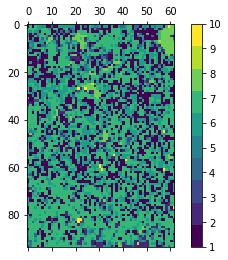

In [55]:
spec_3.plot_segments()

Not really - maybe UMAP+DBSCAN?

In [56]:
spec_3.segment(method="UMAP_DBSCAN",number_of_regions=None,min_cluster_size=5, min_samples=None, n_neighbors=15)

2020-09-26 00:39:49,755  SpectraRegion  INFO: Calculating clusters
2020-09-26 00:39:49,847  SpectraRegion  INFO: UMAP reduction


Elem Matrix (5828, 6146)


2020-09-26 00:40:04,259  SpectraRegion  INFO: HDBSCAN reduction
2020-09-26 00:40:04,345  SpectraRegion  INFO: Calculating clusters done
2020-09-26 00:40:04,467  SpectraRegion  INFO: Calculating clusters saved


array([[  4, 147,   4, ...,   4,   4,  31],
       [  4,  -1,   6, ...,   1,   2,   2],
       [ 50, 145, 100, ...,   2,   2,   2],
       ...,
       [ -1,  -1,  -1, ..., 116,   4,  27],
       [ -1,   3,  92, ..., 100, 139, 139],
       [  4,   3,  24, ...,  27, 100,  -1]], dtype=int16)

0.0 0.9714285714285714
5828
818


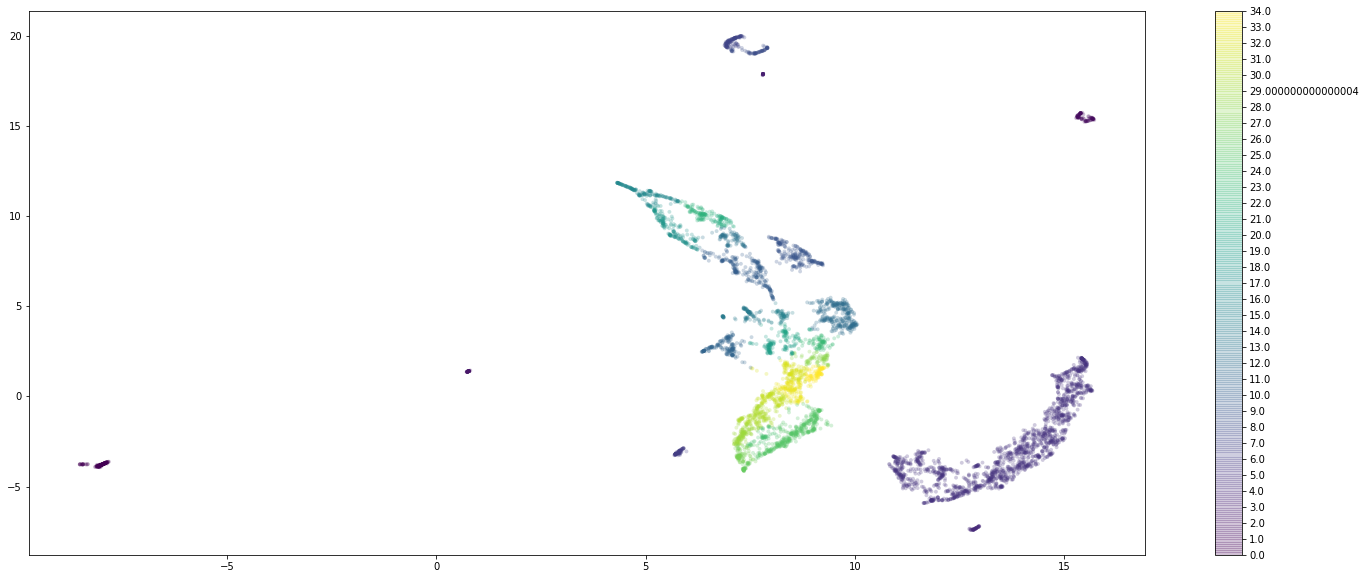

In [57]:
projection = spec_3.dimred_elem_matrix#umap.UMAP().fit_transform(spec_percentile.dimred_elem_matrix)

clusterer = hdbscan.HDBSCAN(min_cluster_size=20, prediction_data=True,gen_min_span_tree=True).fit(spec_3.dimred_elem_matrix)

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

cluster_labels = [np.argmax(x) for x in soft_clusters]

uniqueLabels = sorted(set(cluster_labels))
numLabels = len(cluster_labels)

cluster_colors = [x/len(uniqueLabels) for x in cluster_labels]

mpl.rcParams['figure.figsize'] = (25,10)
sp = plt.scatter(*projection.T, s=15, linewidth=0, c=cluster_colors, cmap="viridis", alpha=0.25)

valid_vals = np.unique(cluster_colors)
min_ = min(valid_vals)
max_ = max(valid_vals)

print(min_, max_)

positions = np.linspace(min_, max_, len(valid_vals))
val_lookup = dict(zip(positions, valid_vals))

def formatter_func(x, pos):
    'The two args are the value and tick position'
    val = val_lookup[x] * len(valid_vals)
    return val

formatter = plt.FuncFormatter(formatter_func)
plt.colorbar(sp, ticks=positions, format=formatter, spacing='proportional')

mpl.rcParams['figure.figsize'] = (6,4)

print(numLabels)
print(sum(clusterer.labels_ == -1))


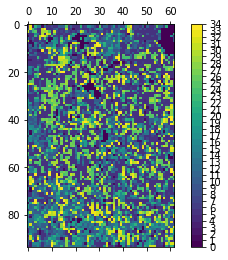

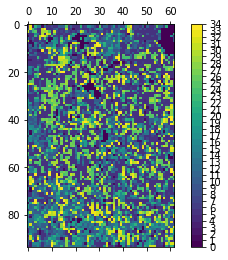

In [58]:
hdblabels = np.reshape(cluster_labels, (94,62))
spec_3.plot_array(plt.gcf(), hdblabels)

Also does not work ... supervised?

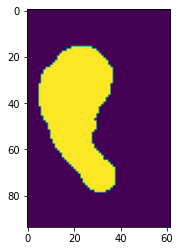

In [59]:
manual_mask = 1-np.round(rgb2gray(rgba2rgb(imageio.imread("aorta_test_lipids_2.png"))))
plt.imshow(manual_mask)

In [60]:
shapePixels = set()
bgPixels = set()

for x in range(0, spectra_orig3.shape[0]):
    for y in range(0, spectra_orig3.shape[1]):
        
        if manual_mask[x,y] >= 0.5:
            shapePixels.add((x,y))
        else:
            bgPixels.add((x,y))

In [61]:
spectra = np.array(sp3_called_nobg)
spectra_masses = np.array(sp3_called_nobg_masses)

In [62]:
print("Included pixels", len(shapePixels), len(bgPixels))

testPixels_aorta = random.sample(shapePixels, 300)
testPixels_bg = random.sample(bgPixels, 300)

Included pixels 1338 4490


In [63]:

values_train = []
classes_train = []

values_test = []
classes_test = []

values_all = []
classes_all = []

for x in range(0, spectra.shape[0]):
    for y in range(0, spectra.shape[1]):
        
        if (x,y) in testPixels_aorta:
            values_test.append(spectra[x,y,:])
            classes_test.append(1)
            continue           
        if (x,y) in testPixels_bg:
            values_test.append(spectra[x,y,:])
            classes_test.append(0)
            continue
        
        if manual_mask[x,y] < 0.5:
            
            values_train.append(spectra[x,y,:])
            classes_train.append(0)
            
            values_all.append(spectra[x,y,:])
            classes_all.append(0)
            
        else:
            
            values_train.append(spectra[x,y,:])
            classes_train.append(1)
            
            values_all.append(spectra[x,y,:])
            classes_all.append(1)
        
        
print("Train size", len(values_train))
print("Test size", len(values_test))

Train size 5228
Test size 600


In [64]:
subsetIdx = random.sample([x for x in range(0, len(values_train))], 600)
subsetIdx = [x for x in range(0, len(values_train))]

values_train_sub = []
classes_train_sub = []

for sIdx in subsetIdx:
    values_train_sub.append( values_train[sIdx] )
    classes_train_sub.append( classes_train[sIdx] )
    
print("Subsetted", len(values_train_sub))

Subsetted 5228


In [65]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(values_all, classes_all)

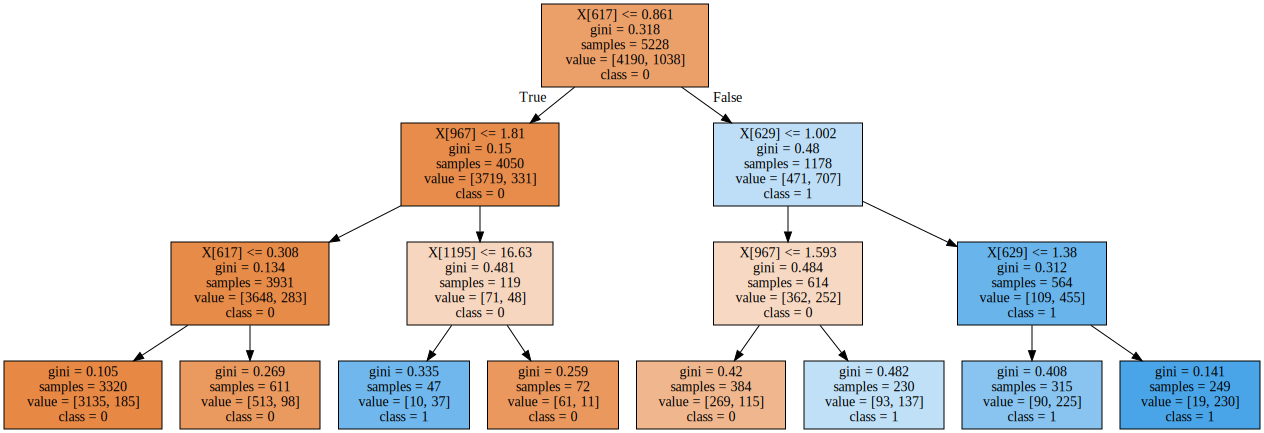

In [66]:
graph = Source(tree.export_graphviz(clf, out_file=None
   , class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

2020-09-26 00:40:07,032  SpectraRegion  INFO: Processing Mass 616.25 with best existing mass 616.25


617 616.25


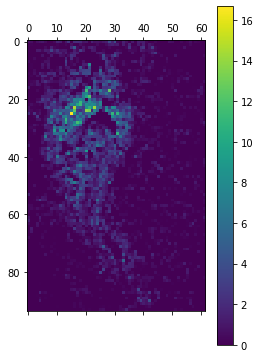

2020-09-26 00:40:07,144  SpectraRegion  INFO: Processing Mass 703.75 with best existing mass 703.75


967 703.75


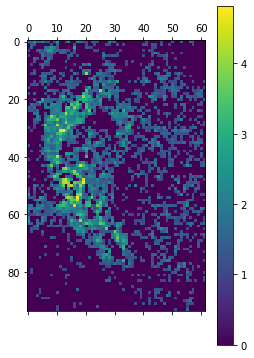

2020-09-26 00:40:07,251  SpectraRegion  INFO: Processing Mass 731.75 with best existing mass 731.75


1079 731.75


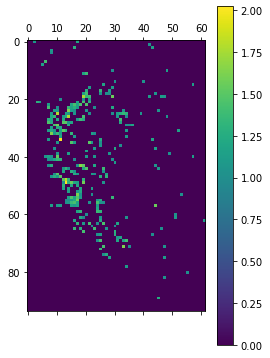

2020-09-26 00:40:07,361  SpectraRegion  INFO: Processing Mass 1585.0 with best existing mass 1585.0


4492 1585.0


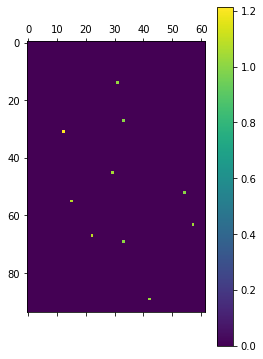

2020-09-26 00:40:07,463  SpectraRegion  INFO: Processing Mass 853.75 with best existing mass 853.75


1567 853.75


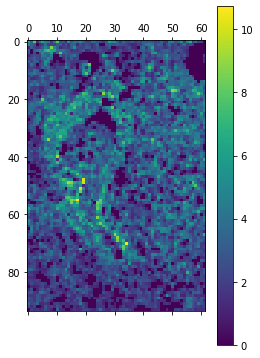

2020-09-26 00:40:07,566  SpectraRegion  INFO: Processing Mass 1588.25 with best existing mass 1588.25


4505 1588.25


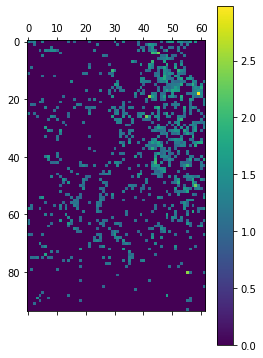

2020-09-26 00:40:07,834  SpectraRegion  INFO: Processing Mass 1618.25 with best existing mass 1618.25


4625 1618.25


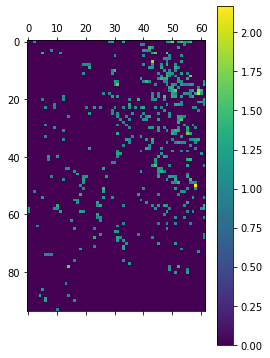

2020-09-26 00:40:07,945  SpectraRegion  INFO: Processing Mass 844.5 with best existing mass 844.5


1530 844.5


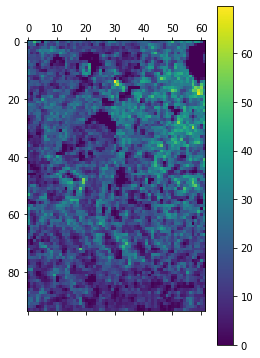

2020-09-26 00:40:08,053  SpectraRegion  INFO: Processing Mass 840.5 with best existing mass 840.5


1514 840.5


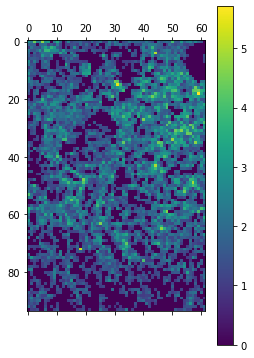

2020-09-26 00:40:08,160  SpectraRegion  INFO: Processing Mass 787.75 with best existing mass 787.75


1303 787.75


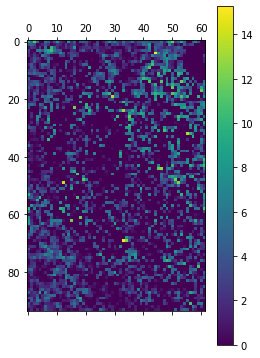

2020-09-26 00:40:08,263  SpectraRegion  INFO: Processing Mass 797.25 with best existing mass 797.25


1341 797.25


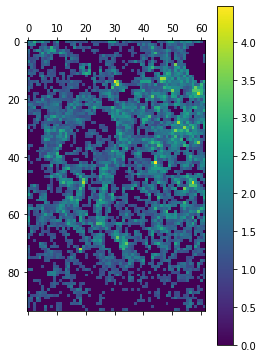

In [67]:
treeMasses = set()
for mzIdx in [617,967,1079,4492,1567,4505,4625,1530,1514,1303,1341]:
    mzVal = spec_3.idx2mass[mzIdx]
    
    print(mzIdx, mzVal)
    treeMasses.add(mzVal)
    spec_3.mass_heatmap(mzVal)

5066 5828 0.8692518874399451


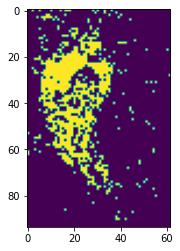

In [68]:
trues = np.zeros((spectra.shape[0], spectra.shape[1]))

trueEvals = 0

for x in range(0, spectra.shape[0]):
    for y in range(0, spectra.shape[1]):
        
        
        retVal = clf.predict_proba([ spectra[x,y,:] ])[0]
        pred_label = np.argmax(retVal)
        
        if pred_label == 1:
            trues[x,y] = 1
            
        if pred_label == manual_mask[x,y]:
            trueEvals += 1
            
print(trueEvals, spectra.shape[0]*spectra.shape[1], trueEvals / (spectra.shape[0]*spectra.shape[1]))
plt.imshow(trues)

2020-09-26 00:40:08,900  SpectraRegion  INFO: Processing Mass 703.75 with best existing mass 703.75


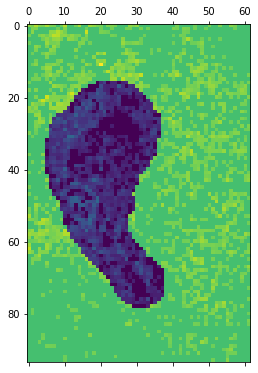

In [69]:
#617.1254264732984
#741.5511417902636
mm = np.round(rgb2gray(rgba2rgb(imageio.imread("aorta_test_lipids_2.png"))))

plt.matshow(spec_3.mass_heatmap(703.75, plot=False)*0.1+mm)

In [70]:
def eval_mass(mass, intens, comp, spectra, manual, weights=None):
    
    if weights == None:
        weights = (1,1)
    #bg if comp True
    
    bgPixels = 0
    shapePixels = 0
    
    bgCorr = 0
    bgIncorr = 0
    
    shapeCorr = 0
    shapeIncorr = 0

    for x in range(0, spectra.shape[0]):
        for y in range(0, spectra.shape[1]):
            
            pred = 1 if comp(spectra[x,y,mass], intens) else 0
            
            if manual[x,y] == 1:
                shapePixels += 1
                
                if pred == 1:
                    shapeCorr += 1
                else:
                    shapeIncorr += 1
                
            if manual[x,y] == 0:
                bgPixels += 1
                
                if pred == 0:
                    bgCorr += 1
                else:
                    bgIncorr += 1
            
    #print(bgCorr, bgIncorr, bgPixels)    
    #print(shapeCorr, shapeIncorr, shapePixels)    
    
    avgPixels = (bgPixels + shapePixels)/2
        
    bgCorrRate = bgCorr / bgPixels
    shapeCorrRate = shapeCorr / shapePixels
    
    return (weights[0]*shapeCorrRate + weights[1]*bgCorrRate) / sum(weights)

In [71]:
percentileMassIndices = []
supervisedPercentileIndices = []

bar = progressbar.ProgressBar(widgets=[
        progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
    ])

bgCount = sum(sum(manual_mask == 1))
shapeCount = sum(sum(manual_mask == 0))

for mass in bar(range(0, spectra.shape[2])):
        
    bgValues = [spectra[x,y,mass] for (x,y) in bgPixels]
    shapeValues = [spectra[x,y,mass] for (x,y) in shapePixels]
    
    bgMean = np.mean(bgValues)
    shapeMean = np.mean(shapeValues)
    
    intenseThreshold = (bgMean + shapeMean) / 2.0
    ec = eval_mass(mass, intens=intenseThreshold, comp=lambda x,y: x>y, spectra=spectra, manual=manual_mask, weights = (2, 1) )
    
    pcVals = np.percentile(bgValues+shapeValues, [85, 99])
    
    if pcVals[1]-pcVals[0] > 0.01 and pcVals[0] < 0.0001:
        percentileMassIndices.append(mass)
        
        if len(percentileMassIndices) > 0 and len(percentileMassIndices) % 10 == 0:
            print("masses", len(percentileMassIndices))

    if ec > 0.7:
        print(mass, ec, bgMean, shapeMean)
        supervisedPercentileIndices.append(mass)
        

    
print("Found percentile masses", len(percentileMassIndices))

|#                                                        |   3% ETA:   0:00:49

masses 10


|##                                                       |   5% ETA:   0:00:47

masses 20


|###                                                      |   6% ETA:   0:00:46

masses 30


|###                                                      |   6% ETA:   0:00:45

masses 40


|####                                                     |   8% ETA:   0:00:44

masses 50


|#####                                                    |   9% ETA:   0:00:43

masses 60


|#####                                                    |  10% ETA:   0:00:43

masses 70


|######                                                   |  11% ETA:   0:00:43

masses 80


|######                                                   |  11% ETA:   0:00:42

masses 90


|#######                                                  |  12% ETA:   0:00:42

masses 100


|#######                                                  |  13% ETA:   0:00:41

masses 110


|########                                                 |  15% ETA:   0:00:40

masses 120


|#########                                                |  16% ETA:   0:00:40

967 0.7173627271143426 0.42231915323665253 1.4794297430369174
masses 130


|##########                                               |  17% ETA:   0:00:39

masses 140


|##########                                               |  18% ETA:   0:00:39

masses 150
masses 160


|##########                                               |  19% ETA:   0:00:38

masses 170
masses 180


|###########                                              |  20% ETA:   0:00:38

masses 190


|###########                                              |  20% ETA:   0:00:37

masses 200


|############                                             |  21% ETA:   0:00:37

masses 210
masses 220


|#############                                            |  23% ETA:   0:00:36

masses 230
masses 240


|#############                                            |  24% ETA:   0:00:36

masses 250


|##############                                           |  24% ETA:   0:00:36

masses 260
masses 270


|##############                                           |  25% ETA:   0:00:35

masses 280
masses 290


|###############                                          |  26% ETA:   0:00:35

masses 300


|###############                                          |  27% ETA:   0:00:35

masses 310
masses 320


|################                                         |  28% ETA:   0:00:34

masses 330


|################                                         |  28% ETA:   0:00:34

masses 340


|################                                         |  29% ETA:   0:00:33

masses 350
masses 360


|#################                                        |  30% ETA:   0:00:33

masses 370
masses

|#################                                        |  31% ETA:   0:00:33

 380


|##################                                       |  31% ETA:   0:00:32

masses 390


|##################                                       |  32% ETA:   0:00:32

masses 400


|###################                                      |  33% ETA:   0:00:31

masses 410


|###################                                      |  34% ETA:   0:00:31

masses 420


|####################                                     |  35% ETA:   0:00:31

masses 430


|####################                                     |  35% ETA:   0:00:30

masses 440


|####################                                     |  36% ETA:   0:00:30

masses 450


|#####################                                    |  37% ETA:   0:00:30

masses 460


|#####################                                    |  38% ETA:   0:00:29

masses 470


|######################                                   |  39% ETA:   0:00:29

masses 480


|######################                                   |  39% ETA:   0:00:28

masses 490


|#######################                                  |  41% ETA:   0:00:28

masses 500


|########################                                 |  42% ETA:   0:00:27

masses 510


|##########################                               |  45% ETA:   0:00:26

masses 520


|############################                             |  50% ETA:   0:00:23

masses 530


|#################################                        |  58% ETA:   0:00:20

masses 540


|######################################                   |  67% ETA:   0:00:15

masses 550


|########################################                 |  70% ETA:   0:00:14

masses 560


|#########################################                |  73% ETA:   0:00:12

masses 570


|##########################################               |  74% ETA:   0:00:12

masses 580


|##########################################               |  75% ETA:   0:00:12

masses 590


|###########################################              |  75% ETA:   0:00:11

masses 600


|#########################################################| 100% Time:  0:00:48


Found percentile masses 604


2020-09-26 00:40:57,409  SpectraRegion  INFO: Processing Mass 703.75 with best existing mass 703.75


703.75


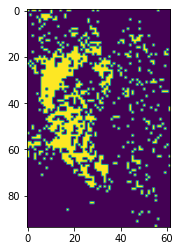

In [72]:
print(spec_3.idx2mass[967])
plt.imshow(spec_3.mass_heatmap(703.75, plot=False) > 1.5)

In [73]:
fcIndices = percentileMassIndices#percentileMassIndices

percentile_peaks = spectra[:,:,fcIndices]
percentile_masses = spectra_masses[fcIndices]

percentile_peaks.shape

(94, 62, 604)

In [74]:
spec_percentile = SpectraRegion(percentile_peaks, percentile_masses)
spec_percentile.calculate_similarity(mode="spectra_log")


2020-09-26 00:40:57,567  SpectraRegion  INFO: Creating C++ obj
2020-09-26 00:40:57,568  SpectraRegion  INFO: 604 (94, 62, 604)
2020-09-26 00:40:57,568  SpectraRegion  INFO: dimensions 604
2020-09-26 00:40:57,569  SpectraRegion  INFO: input dimensions (94, 62, 604)
2020-09-26 00:40:57,570  SpectraRegion  INFO: Switching to dot mode
2020-09-26 00:40:57,575  SpectraRegion  INFO: Starting calc similarity c++


604


2020-09-26 00:41:05,777  SpectraRegion  INFO: outclust dimensions (5828, 5828)
2020-09-26 00:41:05,777  SpectraRegion  INFO: Calculating spectra similarity
2020-09-26 00:41:05,935  SpectraRegion  INFO: Calculating spectra similarity done


array([[0.99999994, 0.09535483, 0.33017424, ..., 0.0522337 , 0.        ,
        0.        ],
       [0.09535483, 0.99999994, 0.02440755, ..., 0.        , 0.        ,
        0.        ],
       [0.33017424, 0.02440755, 1.        , ..., 0.02562319, 0.        ,
        0.        ],
       ...,
       [0.0522337 , 0.        , 0.02562319, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

In [75]:
spec_percentile.segment(method="WARD", number_of_regions=5)

2020-09-26 00:41:05,955  SpectraRegion  INFO: Calculating clusters
2020-09-26 00:41:06,923  SpectraRegion  INFO: Calculating clusters done
2020-09-26 00:41:06,935  SpectraRegion  INFO: Calculating clusters saved


array([[4, 5, 3, ..., 5, 5, 1],
       [5, 5, 4, ..., 5, 1, 1],
       [1, 5, 5, ..., 1, 1, 1],
       ...,
       [5, 5, 5, ..., 3, 3, 5],
       [5, 5, 1, ..., 2, 5, 5],
       [1, 5, 1, ..., 5, 1, 5]], dtype=int16)

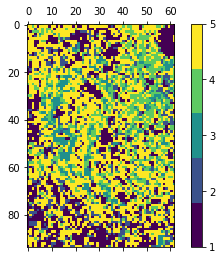

In [76]:
spec_percentile.plot_segments()

In [77]:
spec_percentile.segment(method="UMAP_DBSCAN",number_of_regions=None,min_cluster_size=5, min_samples=None, n_neighbors=15)

2020-09-26 00:41:07,096  SpectraRegion  INFO: Calculating clusters
2020-09-26 00:41:07,116  SpectraRegion  INFO: UMAP reduction


Elem Matrix (5828, 604)


2020-09-26 00:41:16,753  SpectraRegion  INFO: HDBSCAN reduction
2020-09-26 00:41:16,839  SpectraRegion  INFO: Calculating clusters done
2020-09-26 00:41:16,845  SpectraRegion  INFO: Calculating clusters saved


array([[ 97,  17,  53, ..., 112, 114, 149],
       [  5, 121,  97, ...,   4,  76,  -1],
       [ -1,  19,  13, ..., 163, 156,  95],
       ...,
       [ 19, 106,  -1, ...,  37,  37, 106],
       [ 19, 121, 156, ...,  -1,  24,  -1],
       [172,  74,  -1, ...,  19,  -1,  86]], dtype=int16)

0.0 0.9230769230769231
5828
1185


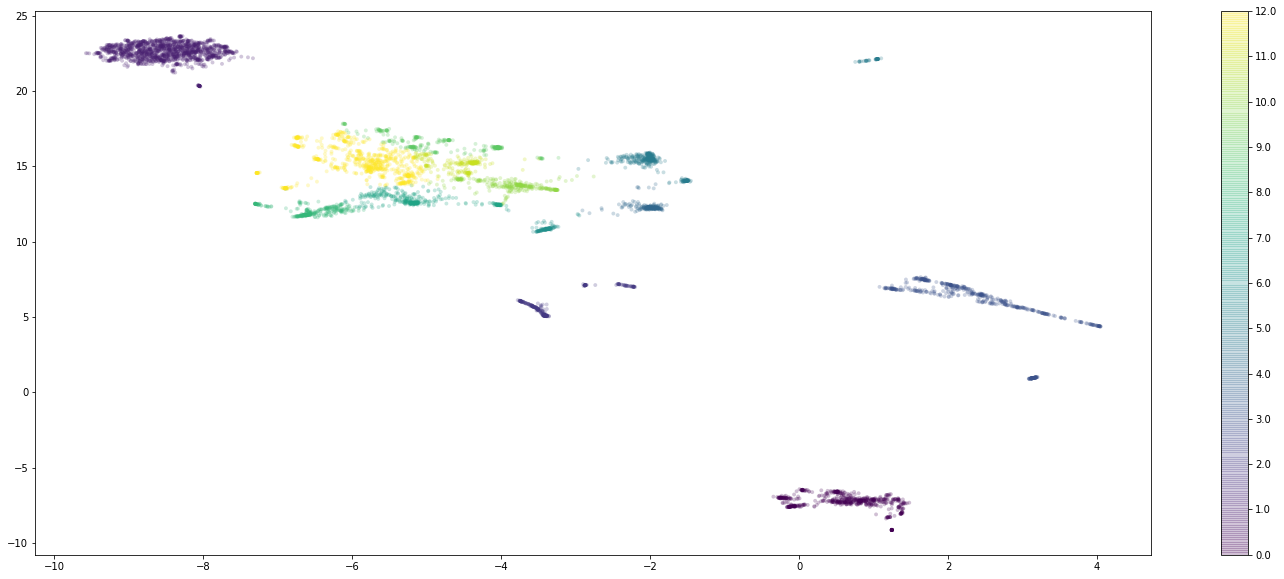

In [78]:
projection = spec_percentile.dimred_elem_matrix#umap.UMAP().fit_transform(spec_percentile.dimred_elem_matrix)

clusterer = hdbscan.HDBSCAN(min_cluster_size=80, prediction_data=True,gen_min_span_tree=True).fit(spec_percentile.dimred_elem_matrix)

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

cluster_labels = [np.argmax(x) for x in soft_clusters]

uniqueLabels = sorted(set(cluster_labels))
numLabels = len(cluster_labels)

cluster_colors = [x/len(uniqueLabels) for x in cluster_labels]

mpl.rcParams['figure.figsize'] = (25,10)
sp = plt.scatter(*projection.T, s=15, linewidth=0, c=cluster_colors, cmap="viridis", alpha=0.25)

valid_vals = np.unique(cluster_colors)
min_ = min(valid_vals)
max_ = max(valid_vals)

print(min_, max_)

positions = np.linspace(min_, max_, len(valid_vals))
val_lookup = dict(zip(positions, valid_vals))

def formatter_func(x, pos):
    'The two args are the value and tick position'
    val = val_lookup[x] * len(valid_vals)
    return val

formatter = plt.FuncFormatter(formatter_func)
plt.colorbar(sp, ticks=positions, format=formatter, spacing='proportional')

mpl.rcParams['figure.figsize'] = (6,4)

print(numLabels)
print(sum(clusterer.labels_ == -1))


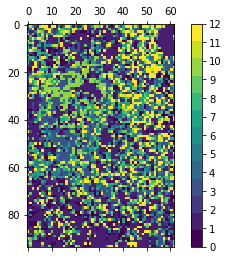

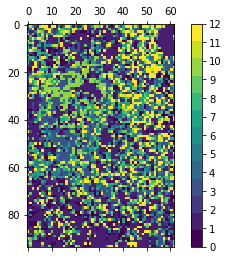

In [79]:
hdblabels = np.reshape(cluster_labels, (94,62))
spec_percentile.plot_array(plt.figure(), hdblabels)

In [ ]:
import seaborn as sns

In [80]:
spec_percentile.dimred_elem_matrix.shape

(5828, 2)

In [88]:
import pandas as pd

In [98]:
df = pd.DataFrame(spec_percentile.elem_matrix.T)

In [110]:
dfPlot = df[df.sum(axis=1) > 700]
dfPlot = np.log2(dfPlot+1)
print(dfPlot.shape)

(87, 5828)


In [128]:
spec_colors = np.reshape(manual_mask, (spec_percentile.elem_matrix.shape[0], 1)).T
print(spec_colors.shape)
class2col = {0: (1,0,0,0), 1: (0,1,0,0)}

print(sum(spec_colors[0,:] == 0) , sum(spec_colors[0,:] == 1))
spec_colors_rgb = [class2col[x] for x in list(spec_colors[0,:])]

(1, 5828)
4490 1338


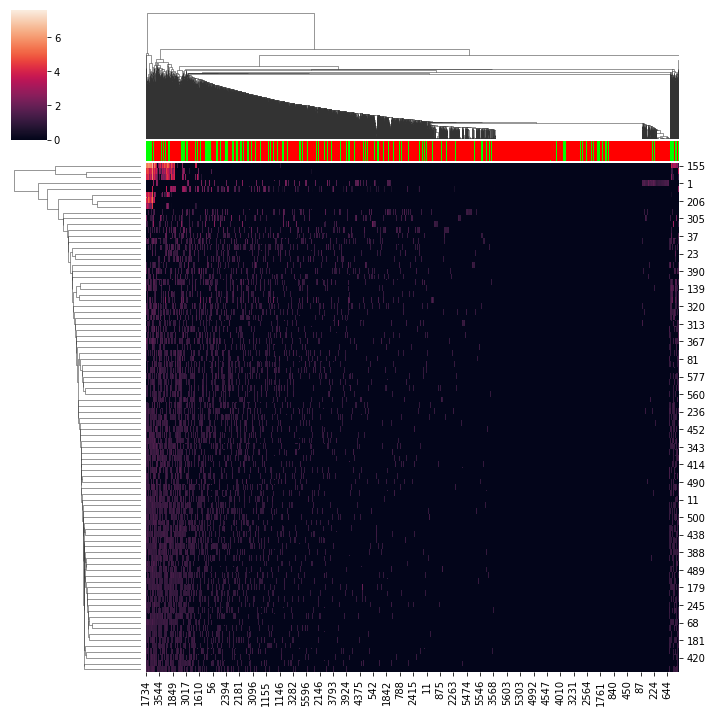

In [131]:
sns.clustermap(dfPlot, col_colors=spec_colors_rgb, row_cluster=True, col_cluster=True)

In [132]:
sp3_called_spectra = SpectraRegion(sp3_called, sp3_called_masses)
sp3_called_spectra.calculate_similarity(mode="spectra_log")


2020-09-26 17:41:33,290  SpectraRegion  INFO: Creating C++ obj
2020-09-26 17:41:33,291  SpectraRegion  INFO: 6156 (94, 62, 6156)
2020-09-26 17:41:33,292  SpectraRegion  INFO: dimensions 6156
2020-09-26 17:41:33,292  SpectraRegion  INFO: input dimensions (94, 62, 6156)
2020-09-26 17:41:33,293  SpectraRegion  INFO: Switching to dot mode
2020-09-26 17:41:33,347  SpectraRegion  INFO: Starting calc similarity c++


6156


2020-09-26 17:42:52,568  SpectraRegion  INFO: outclust dimensions (5828, 5828)
2020-09-26 17:42:52,569  SpectraRegion  INFO: Calculating spectra similarity
2020-09-26 17:42:52,706  SpectraRegion  INFO: Calculating spectra similarity done


array([[1.        , 0.9543262 , 0.9427282 , ..., 0.8964647 , 0.95470315,
        0.9452954 ],
       [0.9543262 , 1.        , 0.920357  , ..., 0.90293187, 0.96233314,
        0.94571567],
       [0.9427282 , 0.920357  , 1.        , ..., 0.8671299 , 0.92657596,
        0.9211583 ],
       ...,
       [0.8964647 , 0.90293187, 0.8671299 , ..., 1.        , 0.9446965 ,
        0.9520632 ],
       [0.95470315, 0.96233314, 0.92657596, ..., 0.9446965 , 1.        ,
        0.98249   ],
       [0.9452954 , 0.94571567, 0.9211583 , ..., 0.9520632 , 0.98249   ,
        1.        ]], dtype=float32)

In [133]:
sp3_called_spectra.segment(method="WARD", number_of_regions=10)

2020-09-26 17:42:52,726  SpectraRegion  INFO: Calculating clusters
2020-09-26 17:42:53,814  SpectraRegion  INFO: Calculating clusters done
2020-09-26 17:42:53,833  SpectraRegion  INFO: Calculating clusters saved


array([[ 6,  3,  8, ...,  7,  7,  3],
       [ 7,  3,  8, ...,  3,  5,  1],
       [ 2,  3,  3, ...,  1,  1,  1],
       ...,
       [10, 10,  3, ...,  3,  8, 10],
       [ 6,  4,  3, ...,  3,  3,  3],
       [ 8,  4,  3, ..., 10,  3,  3]], dtype=int16)

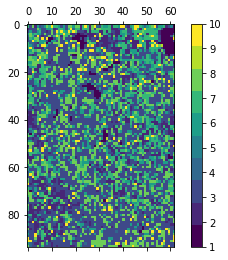

In [134]:
sp3_called_spectra.plot_segments()

In [138]:
sp3_called_spectra.segment(method="UMAP_DBSCAN",number_of_regions=None,min_cluster_size=5, min_samples=None, n_neighbors=15)

2020-09-26 17:43:44,796  SpectraRegion  INFO: Calculating clusters
2020-09-26 17:43:44,893  SpectraRegion  INFO: UMAP reduction


Elem Matrix (5828, 6156)


2020-09-26 17:43:53,717  SpectraRegion  INFO: HDBSCAN reduction
2020-09-26 17:43:53,796  SpectraRegion  INFO: Calculating clusters done
2020-09-26 17:43:53,807  SpectraRegion  INFO: Calculating clusters saved


array([[129, 204, 180, ..., 171, 156,  69],
       [164,  -1,   8, ...,  57,  57,   1],
       [122,  -1, 132, ...,   1,   1,   1],
       ...,
       [  5,  -1,  72, ..., 193,  -1,   5],
       [ -1,   2, 146, ...,  99, 190, 190],
       [ 39,   2,  99, ...,   5,  99,  99]], dtype=int16)

0.0 0.9848484848484849
5828
875


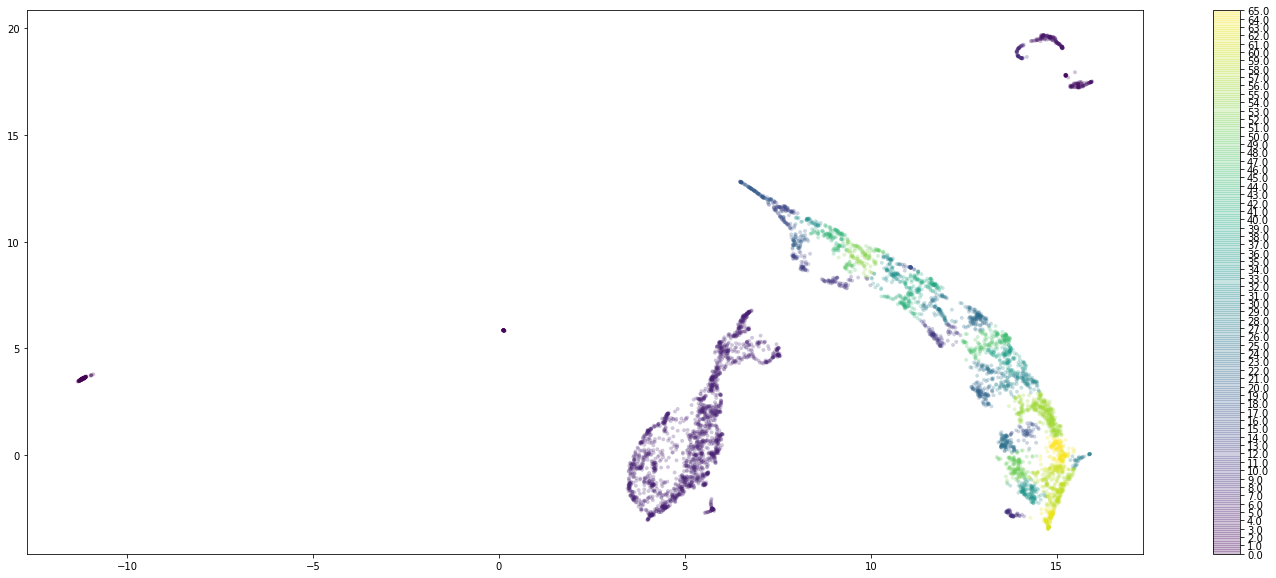

In [144]:
projection = sp3_called_spectra.dimred_elem_matrix#umap.UMAP().fit_transform(spec_percentile.dimred_elem_matrix)

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True,gen_min_span_tree=True).fit(sp3_called_spectra.dimred_elem_matrix)

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

cluster_labels = [np.argmax(x) for x in soft_clusters]

uniqueLabels = sorted(set(cluster_labels))
numLabels = len(cluster_labels)

cluster_colors = [x/len(uniqueLabels) for x in cluster_labels]

mpl.rcParams['figure.figsize'] = (25,10)
sp = plt.scatter(*projection.T, s=15, linewidth=0, c=cluster_colors, cmap="viridis", alpha=0.25)

valid_vals = np.unique(cluster_colors)
min_ = min(valid_vals)
max_ = max(valid_vals)

print(min_, max_)

positions = np.linspace(min_, max_, len(valid_vals))
val_lookup = dict(zip(positions, valid_vals))

def formatter_func(x, pos):
    'The two args are the value and tick position'
    val = val_lookup[x] * len(valid_vals)
    return val

formatter = plt.FuncFormatter(formatter_func)
plt.colorbar(sp, ticks=positions, format=formatter, spacing='proportional')

mpl.rcParams['figure.figsize'] = (6,4)

print(numLabels)
print(sum(clusterer.labels_ == -1))


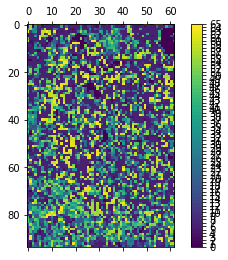

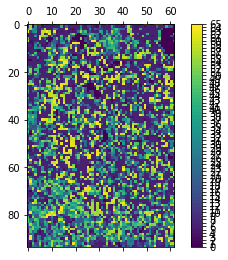

In [145]:
hdblabels = np.reshape(cluster_labels, (94,62))
sp3_called_spectra.plot_array(plt.gcf(), hdblabels)